# Hello world

In [5]:
import os
import openai

def GPT_Completion(texts):## Call the API key under your account (in a secure way)
    openai.api_key = "***REMOVED***"

    response = openai.Completion.create(engine="text-davinci-002",
                                        prompt =  texts,
                                        temperature = 0.6,
                                        top_p = 1,
                                        max_tokens = 64,
                                        frequency_penalty = 0,
                                        presence_penalty = 0)
    return print(response.choices[0].text)

recipe = 'Provide a cooking recipe based on the following ingredients: \\n \nApple \
          \n \nFlour \
          \n \nChicken \
          \n \nSalt'

GPT_Completion(recipe)



Apple Chicken:

1. Preheat oven to 375 degrees.
2. Coat chicken in flour.
3. Place chicken in a baking dish.
4. Cut apples into thin slices and place on top of chicken.
5. Sprinkle with salt.
6. Bake for 30 minutes


# Generate training dataset

## Create workspace

In [ ]:
!mkdir dataset
!mkdir dataset/problems/
!mkdir dataset/plans/
!mkdir dataset/plans_ipc/
!mkdir dataset/formatted/
!mkdir dataset/plans_ipc/
!mkdir dataset/batches
!mkdir dataset/batches/500/problems
!mkdir dataset/batches/500/plans
!mkdir dataset/batches/1000/problems
!mkdir dataset/batches/1000/plans
!mkdir dataset/batches/2000/problems
!mkdir dataset/batches/2000/plans
!mkdir dataset/batches/4000/problems
!mkdir dataset/batches/4000/plans
!mkdir dataset/batches/8000/problems
!mkdir dataset/batches/8000/plans
!mkdir dataset/batches/validation/problems
!mkdir dataset/batches/validation/plans
!mkdir dataset/batches/validation/results/500
!mkdir dataset/batches/validation/results/1000
!mkdir dataset/batches/validation/results/2000
!mkdir dataset/batches/validation/results/4000
!mkdir dataset/batches/validation/results/8000
!mkdir dataset/batches/validation/results/500
!mkdir dataset/batches/validation/results/500
!mkdir dataset/batches/validation/results/1000/plans
!mkdir dataset/batches/validation/results/1000/val
!mkdir dataset/batches/validation/results/2000/plans
!mkdir dataset/batches/validation/results/2000/val
!mkdir dataset/batches/validation/results/4000/plans
!mkdir dataset/batches/validation/results/4000/val
!mkdir dataset/batches/validation/results/8000/plans
!mkdir dataset/batches/validation/results/8000/val
!mkdir dataset/batches/validation/unsolved
!mkdir dataset/batches/validation/unsolved/problems
!mkdir dataset/batches/validation/unsolved/plans
!mkdir dataset/batches/validation/unsolved/val_plans
!mkdir dataset/batches/validation/unsolved/val
!mkdir dataset/test/
!mkdir dataset/test/problems
!mkdir dataset/test/plans
!mkdir dataset/test/val


## Generate problems

In [3]:
import os
import filecmp

## cleaning work directories 
!rm dataset/problems/* &> /dev/null
!rm dataset/plans/* &> /dev/null
!rm dataset/plans_ipc/* &> /dev/null
!rm dataset/formatted/* &> /dev/null

## 8000 data points should improve performance between 2x and 4x
%run generator/pddl_confgen.py 4 9000 -r 24 -co
!mv -v generator/problems/conditional/* dataset/problems > /dev/null

## clean duplicates

problems = sorted(os.listdir('./dataset/problems/'))

duplicates = 0
to_be_removed = []

for i, problem_i in enumerate(problems):
    print("Cleaning --- " + str(round((i / len(problems) * 100), 1)) +"%", end = '\r')
    for problem_j in problems[i + 1:]:
        if filecmp.cmp('./dataset/problems/' + problem_i, 
                       './dataset/problems/' + problem_j, 
                       shallow=False):
            duplicates += 1
            to_be_removed.append(problem_j)
            
for problem in to_be_removed:
    try:
        os.remove('./dataset/problems/' + problem)
    except FileNotFoundError:
        continue
            
print(str(duplicates) + " duplicates deleted")

Writing conditional problem files to /home/alessio/planning/teriyaki/generator/problems/conditional...
Done.
All operations completed. Happy planning!
40 duplicates deleted


## Generate plans with Probe

In [4]:
import os
import subprocess

problems = sorted(os.listdir('./dataset/problems/'))


for i, problem in enumerate(problems):
    
    result = subprocess.run(['./generator/probe', 
                             '-d', './dataset/domains/domain_m_25_B.pddl', 
                             '-i', './dataset/problems/' + problem,
                             '-o', './dataset/plans/m_25_B-' + str(problem.split('_',2)[2:][0])], 
                             stdout=subprocess.PIPE)
    print("Planning --- " + str(round((i / len(problems) * 100), 1)) +"%", end = '\r')
    
#     # temporarly limit to 400 samples
#     if i > 500: break

print("Planning complete")

terminate called after throwing an instance of 'std::bad_alloc'
  what():  std::bad_alloc


terminate called after throwing an instance of 'std::bad_alloc'
  what():  std::bad_alloc


Planning complete0%


## Convert Probe plans to IPC format

In [1]:
import os

# clean working directories
!rm dataset/plans_ipc/* &> /dev/null

plans = sorted(os.listdir('./dataset/plans/'))

for plan in plans:
    probe = open('./dataset/plans/' + plan, "r")
    val = open('./dataset/plans_ipc/' + plan.split(".")[0] + ".plan", 'w+')
    replacement = ""
    # using the for loop
    action_timing = 1
    for line in probe:
        line = line.lower()
        line = '%.3f' % (action_timing / 1000) + "00: " + line
        val.write(line)
        action_timing += 2

    probe.close()
    val.close()
    
print("Plans converted to IPC format")

Plans converted to IPC format


## Validate and remove invalid plans using VAL Validate
This step takes a lot of time and usually all plans are validated. **It can be skipped**.

In [49]:
import os
import subprocess

plans = sorted(os.listdir('./dataset/plans_ipc/'))
invalid_plans = 0

for i, plan in enumerate(plans):
    result = subprocess.run(['./generator/Validate', 
                             './dataset/domains/domain_m_25_B.pddl', 
                             './dataset/problems/problem_conditional_' + plan.split("-")[1].split(".")[0] + ".pddl",
                             './dataset/plans_ipc/' + plan], 
                             stdout=subprocess.PIPE)
    if "Plan failed to execute" in str(result):
        invalid_plans += 1
#         os.remove('./dataset/plans_ipc/m_25_B-' + problem.split('_',2)[2:][0].split(".")[0] + ".plan")
#         os.remove('./dataset/problems/' + problem)

    print("Validating --- " + str(round((i / len(plans) * 100), 1)) +"%", end = '\r')

print('%i plans could not be validated and have been removed from the dataset' % invalid_plans)

965 plans could not be validated and have been removed from the dataset


## Sort problem & plans in batch folders
By deafult, we created several datasets so that the total number of samples used for fine tuning doubles aeach time, starting from the minimum 500 samples up to the recommendend 8000 maximum.

We also create an additional validation batch of ~1000 sample.

In [33]:
import os
import shutil

## cleaning work directories 
!rm dataset/batches/500/problems/* &> /dev/null
!rm dataset/batches/500/plans/* &> /dev/null
!rm dataset/batches/1000/problems/* &> /dev/null
!rm dataset/batches/1000/plans/* &> /dev/null
!rm dataset/batches/2000/problems/* &> /dev/null
!rm dataset/batches/2000/plans/* &> /dev/null
!rm dataset/batches/4000/problems/* &> /dev/null
!rm dataset/batches/4000/plans/* &> /dev/null
!rm dataset/batches/8000/problems/* &> /dev/null
!rm dataset/batches/8000/plans/* &> /dev/null
!rm dataset/batches/validation/problems/* &> /dev/null
!rm dataset/batches/validation/plans/* &> /dev/null
!rm dataset/batches/validation/unsolved/problems/* &> /dev/null
!rm dataset/batches/validation/unsolved/plans/* &> /dev/null
!rm dataset/batches/validation/unsolved/val/* &> /dev/null
!rm dataset/batches/validation/unsolved/plans_val/* &> /dev/null

## fetching and sorting problems and plans

problems = sorted(os.listdir('./dataset/problems/'))
plans = sorted(os.listdir('./dataset/plans_ipc/'))

for i, plan in enumerate(plans):
    if i < 500:
        shutil.move('./dataset/problems/problem_conditional_' + plan.split("-")[1].split(".")[0] + ".pddl", 
                     './dataset/batches/500/problems/')
        shutil.move('./dataset/plans_ipc/' + plans[i], './dataset/batches/500/plans/')
    elif i < 1000:
        shutil.move('./dataset/problems/problem_conditional_' + plan.split("-")[1].split(".")[0] + ".pddl", 
                     './dataset/batches/1000/problems/')
        shutil.move('./dataset/plans_ipc/' + plans[i], './dataset/batches/1000/plans/')
    elif i < 2000:
        shutil.move('./dataset/problems/problem_conditional_' + plan.split("-")[1].split(".")[0] + ".pddl", 
                     './dataset/batches/2000/problems/')
        shutil.move('./dataset/plans_ipc/' + plans[i], './dataset/batches/2000/plans/')
    elif i < 4000:
        shutil.move('./dataset/problems/problem_conditional_' + plan.split("-")[1].split(".")[0] + ".pddl", 
                     './dataset/batches/4000/problems/')
        shutil.move('./dataset/plans_ipc/' + plans[i], './dataset/batches/4000/plans/')
    elif i < 8000:
        shutil.move('./dataset/problems/problem_conditional_' + plan.split("-")[1].split(".")[0] + ".pddl", 
                     './dataset/batches/8000/problems/')
        shutil.move('./dataset/plans_ipc/' + plans[i], './dataset/batches/8000/plans/')
    else:
        shutil.move('./dataset/problems/problem_conditional_' + plan.split("-")[1].split(".")[0] + ".pddl", 
                     './dataset/batches/validation/problems/')
        shutil.move('./dataset/plans_ipc/' + plans[i], './dataset/batches/validation/plans/')

## move unsolved problems to the validation folder to be attempted later by Teriyaki

problems = sorted(os.listdir('./dataset/problems/'))
for problem in problems:
    shutil.move('./dataset/problems/' + problem, './dataset/batches/validation/unsolved/problems/' + problem)
    
print('All problems and plans have been sorted into batches.')

mkdir: cannot create directory ‘dataset/batches/validation/unsolved’: File exists
mkdir: cannot create directory ‘dataset/batches/validation/unsolved/problems’: File exists
mkdir: cannot create directory ‘dataset/batches/validation/unsolved/plans’: File exists
All problems and plans have been sorted into batches.


## Compile GPT3 training datasets

This step will compile `jsonl` for all training batches. Later you can use each of them to increment the fine tuning dataset size progressively.

Unfortunately, before use you need to manually run in a terminal the following line for each of them:

```>openai tools fine_tunes.prepare_data -f './dataset/batches/[YOUR_BATCH]/teriyaki.jsonl```

=====================================================

TODO: `joint3)\n)\n)\n` is seen as part of the prompt

From the documentation regarding conditional generation:
* Use a separator at the end of the prompt, e.g. \n\n###\n\n. Remember to also append this separator when you eventually make requests to your model.
* Use an ending token at the end of the completion, e.g. END
* Remember to add the ending token as a stop sequence during inference, e.g. stop=[" END"]
* Aim for at least ~500 examples
* Ensure that the **prompt + completion doesn't exceed 2048 tokens**, including the separator
* Ensure the examples are of high quality and follow the same desired format
* Ensure that the dataset used for finetuning is very similar in structure and type of task as what the model will be used for
* Using Lower learning rate and only 1-2 epochs tends to work better for these use cases

Example:
```{"prompt":"<Product Name>\n<Wikipedia description>\n\n###\n\n", "completion":" <engaging ad> END"}```

In [21]:
import os
import subprocess

batches = ["500", "1000", "2000", "4000", "8000", "validation"]

for batch in batches:
    dataset = open('./dataset/batches/' + batch + '/teriyaki.jsonl', 'w+')
    plans = sorted(os.listdir('./dataset/batches/' + batch + '/plans/'))

    # extracting prompts from problems and completions from IPC plans 
    for i, plan in enumerate(plans):
        plan_f = open('./dataset/batches/' + batch + '/plans/' + plan, "r")
        problem_f = open('./dataset/batches/' + batch + '/problems/problem_conditional_' + plan.split("-")[1].split(".")[0] + ".pddl", "r")
        lines = problem_f.readlines()

        # lines[49:62] is the range of meaningful predicates at initial state
        dataset.write(repr('{"prompt":"\n(:init\n' + ''.join(lines[49:-1]).replace("    ", "") + 
              '\n\n###\n\n", "completion":" ' + plan_f.read().replace("    ", "") + ' END"}')[1:-1] + "\n")

    dataset.close()

print("Datasets ready!")
print("Before training, run in a terminal\n\t>openai tools fine_tunes.prepare_data -f './dataset/batches/[YOUR_BATCH]/teriyaki.jsonl'")

Datasets ready!
Before training, run in a terminal
	>openai tools fine_tunes.prepare_data -f './dataset/batch/[YOUR_BATCH]/teriyaki.jsonl'


## Compute training cost
`1 token ~= 4 chars
0.0300$/1K Tokens`

In practice it is ~15$ per 1000 samples for this specific planning domain

In [23]:
import os

dataset = open('./dataset/batches/500/teriyaki.jsonl', 'r')
chars = len(dataset.read())
dataset.close()
tokens = chars / 4
cost = tokens * 0.00003

print("Training this dataset will consume about {0} tokens for an estimated cost of {1}$".format(tokens, round(cost,2)))

Training this dataset will consume about 157412.5 tokens for an estimated cost of 4.72$


## Creating a fine-tuned model!

### Dataset 
From the documentation regarding conditional generation:
* Aim for at least ~500 examples (8000 recommended)
* Ensure that the prompt + completion doesn't exceed 2048 tokens, including the separator
* Ensure the examples are of high quality and follow the same desired format
* Ensure that the dataset used for finetuning is very similar in structure and type of task as what the model will be used for
* Using Lower learning rate and only 1-2 epochs tends to work better for these use cases

LEARN MORE ABOUT VALIDATION, DELETING, AND SUFFIX @ 

https://beta.openai.com/docs/guides/fine-tuning/advanced-usage

https://beta.openai.com/docs/api-reference/fine-tunes

### Training hyperparameters
* `model` use `'davinci'` or `'code-davinci-002'` (CODEX, not yet supported)
* `n_epochs` defaults to 4. The number of epochs to train the model for. An epoch refers to one full cycle through the training dataset. For generative use cases 2 epochs is generally better.
* `batch_size` defaults to ~0.2% of the number of examples in the training set, capped at 256. Larger batch sizes tend to work better for larger datasets.
* `learning_rate_multiplier`defaults to 0.05, 0.1, or 0.2 depending on final `batch_size`. We recommend experimenting with values in the range 0.02 to 0.2. Larger learning rates often perform better with larger batch sizes.
* `compute_classification_metrics`defaults to False. If True, for fine-tuning for classification tasks, computes classification-specific metrics (accuracy, F-1 score, etc) on the validation set at the end of every epoch.

### Results
The _results.csv file contains a row for each training step, where a step refers to one forward and backward pass on a batch of data. In addition to the step number, each row contains the following fields corresponding to that step:

* `elapsed_tokens`: the number of tokens the model has seen so far (including repeats)
* `elapsed_examples`: the number of examples the model has seen so far (including repeats), where one example is one element in your batch. For example, if batch_size = 4, each step will increase elapsed_examples by 4.
* `training_loss`: loss on the training batch
* `training_sequence_accuracy`: the percentage of completions in the training batch for which the model's predicted tokens matched the true completion tokens exactly. For example, with a batch_size of 3, if your data contains the completions [[1, 2], [0, 5], [4, 2]] and the model predicted [[1, 1], [0, 5], [4, 2]], this accuracy will be 2/3 = 0.67
* `training_token_accuracy`: the percentage of tokens in the training batch that were correctly predicted by the model. For example, with a batch_size of 3, if your data contains the completions [[1, 2], [0, 5], [4, 2]] and the model predicted [[1, 1], [0, 5], [4, 2]], this accuracy will be 5/6 = 0.83

In [81]:
import os
import openai
import requests

# -t jsonl file of the dataset to be used for fine tuning
# -v jsonl file of the validation dataset

!openai -k ***REMOVED*** \
api fine_tunes.create -t './dataset/batches/500/teriyaki.jsonl' \
-v './dataset/batches/validation/teriyaki.jsonl' \
-m 'davinci' --suffix "teriyaki-001" --n_epochs 2

[2022-11-30 23:20:17] Created fine-tune: ft-JNw1L5bGAnUwJdxSXQAQrdbj
[2022-11-30 23:20:25] Fine-tune costs $109.78
[2022-11-30 23:20:25] Fine-tune enqueued. Queue number: 5
[2022-11-30 23:25:17] Fine-tune is in the queue. Queue number: 4
[2022-12-01 00:08:39] Fine-tune is in the queue. Queue number: 3
[2022-12-01 00:12:43] Fine-tune is in the queue. Queue number: 2
[2022-12-01 00:13:08] Fine-tune is in the queue. Queue number: 1
[2022-12-01 00:22:56] Fine-tune is in the queue. Queue number: 0
[2022-12-01 00:24:34] Fine-tune started
[2022-12-01 00:56:47] Completed epoch 1/2
[2022-12-01 01:27:47] Completed epoch 2/2
[2022-12-01 01:28:34] Uploaded model: davinci:ft-teriyaki:teriyaki-001-2022-12-01-00-28-34
[2022-12-01 01:28:36] Uploaded result file: file-ce5w8Wzv6QmWtO33b9VY5s6P
[2022-12-01 01:28:36] Fine-tune succeeded

Job complete! Status: succeeded 🎉
Try out your fine-tuned model:

openai api completions.create -m davinci:ft-teriyaki:teriyaki-001-2022-12-01-00-28-34 -p <YOUR_PROMPT>


## Monitor results
Fine tuning takes time but the client disconnects after a timeout.

Use the following code to reconnect and check when it's done. It can be used also for *Further tuning*.

In [ ]:
# -i JOB_ID
!openai -k ***REMOVED*** \
api fine_tunes.follow -i ft-JNw1L5bGAnUwJdxSXQAQrdbj

## Further tuning

### <ins>Remember to update the -t argument to point to the desired batch jsonl file</ins>
Repeat the fine tuning operation for increasingly large batches of samples.

### Planning accuracy on the validation set (100/876 samples)

| Training set size | Job ID | Model ID | Discarded because out of tokens, >1000 | Accuracy |
|-------------------|--------|----------|----------------------------------------|----------|
| **500**  | ft-PXtNnUR8jjnAzIgW1YhRpGrt | davinci:ft-teriyaki:teriyaki-001-2022-11-30-18-48-47 | 23 | 2,0%  |
| **1000** | ft-EFuAgXbaOpytBR8VGcIq4Qfe | davinci:ft-teriyaki:teriyaki-001-2022-11-30-19-48-12 | 24 | 27,0% |
| **2000** | ft-OkqNqBWMm0ATjHB7r2Prsgfj | davinci:ft-teriyaki:teriyaki-001-2022-11-30-21-21-23 |  9 | 59,0% |
| **4000** | ft-cldwwOoDt4xGY2WGtTxJo5yh | davinci:ft-teriyaki:teriyaki-001-2022-11-30-22-07-22 |  3 | 84,0% |
| **8000** | ft-JNw1L5bGAnUwJdxSXQAQrdbj | davinci:ft-teriyaki:teriyaki-001-2022-12-01-00-28-34 |  1 | 95,0% |
|          |                             | **Probe planner**                                    |    | 98,6% |

### Notes
Not our case, but...

```if your new training data is much smaller than your previous training data, you may find it useful to reduce learning_rate_multiplier by a factor of 2 to 4.```

In [59]:
import os
import openai
import requests

# -t jsonl file of the dataset to be used for fine tuning
# -v jsonl file of the validation dataset

!openai -k ***REMOVED*** \
api fine_tunes.create -t './dataset/batches/1000/teriyaki.jsonl' \
-v './dataset/batches/validation/teriyaki.jsonl' \
-m 'davinci:ft-teriyaki:teriyaki-001-2022-11-30-18-48-47' --suffix "teriyaki-001" --n_epochs 2

Upload progress: 100%|███████████████████████| 646k/646k [00:00<00:00, 307Mit/s]
Uploaded file from ./dataset/batches/1000/teriyaki.jsonl: file-WkGWR3hD1sofGiz4lDaFCOJ9
Found potentially duplicated files with name 'teriyaki.jsonl', purpose 'fine-tune' and size 1101044 bytes
file-xQOM754uLyXXJezwzs1BLlSZ
Enter file ID to reuse an already uploaded file, or an empty string to upload this file anyway: ^C



## Save results
We now download the results file for all the fine tunings performed.

The `_results.csv` file contains a row for each training step, where a step refers to one forward and backward pass on a batch of data. In addition to the step number, each row contains the following fields corresponding to that step:

* `elapsed_tokens`: the number of tokens the model has seen so far (including repeats)
* `elapsed_examples`: the number of examples the model has seen so far (including repeats), where one example is one element in your batch. For example, if batch_size = 4, each step will increase elapsed_examples by 4.
* `training_loss`: loss on the training batch
* `training_sequence_accuracy`: the percentage of completions in the training batch for which the model's predicted tokens matched the true completion tokens exactly. For example, with a batch_size of 3, if your data contains the completions [[1, 2], [0, 5], [4, 2]] and the model predicted [[1, 1], [0, 5], [4, 2]], this accuracy will be 2/3 = 0.67
* `training_token_accuracy`: the percentage of tokens in the training batch that were correctly predicted by the model. For example, with a batch_size of 3, if your data contains the completions [[1, 2], [0, 5], [4, 2]] and the model predicted [[1, 1], [0, 5], [4, 2]], this accuracy will be 5/6 = 0.83
* `validation_loss`: loss on the validation batch
* `validation_sequence_accuracy`: the percentage of completions in the validation batch for which the model's predicted tokens matched the true completion tokens exactly. For example, with a batch_size of 3, if your data contains the completion [[1, 2], [0, 5], [4, 2]] and the model predicted [[1, 1], [0, 5], [4, 2]], this accuracy will be 2/3 = 0.67
* `validation_token_accuracy`: the percentage of tokens in the validation batch that were correctly predicted by the model. For example, with a batch_size of 3, if your data contains the completion [[1, 2], [0, 5], [4, 2]] and the model predicted [[1, 1], [0, 5], [4, 2]], this accuracy will be 5/6 = 0.83

In [84]:
response = !openai -k ***REMOVED*** \
api fine_tunes.results -i ft-PXtNnUR8jjnAzIgW1YhRpGrt > dataset/batches/500/results_500.csv

response = !openai -k ***REMOVED*** \
api fine_tunes.results -i ft-EFuAgXbaOpytBR8VGcIq4Qfe > dataset/batches/1000/results_1000.csv

response = !openai -k ***REMOVED*** \
api fine_tunes.results -i ft-OkqNqBWMm0ATjHB7r2Prsgfj > dataset/batches/2000/results_2000.csv

response = !openai -k ***REMOVED*** \
api fine_tunes.results -i ft-cldwwOoDt4xGY2WGtTxJo5yh > dataset/batches/4000/results_4000.csv

response = !openai -k ***REMOVED*** \
api fine_tunes.results -i ft-JNw1L5bGAnUwJdxSXQAQrdbj > dataset/batches/8000/results_8000.csv

print("Done!")

Done!


## Test it!
This is an example of a call to the model.


In [29]:
import os
import openai

def GPT_Completion(texts):## Call the API key under your account (in a secure way)
    openai.api_key = "***REMOVED***"

    response = openai.Completion.create(engine="davinci:ft-teriyaki:teriyaki-001-2022-12-01-00-28-34",
                                        prompt =  texts,
                                        top_p = 1,       # modify ONLY top_p or temperature, not both       
                                        temperature = 0, # argmax
                                        max_tokens = 600,
                                        presence_penalty = 0, # -2 < x < 2, negative favors repetitions
                                        frequency_penalty = 0,
                                        # best_of = 4, # 3-5 work well for code completion
                                        stop = "END")
    return print(response.choices[0].text)

problem = '(:init\n(angle_joint angle0 joint1)\n(angle_joint angle345 joint2)\n(angle_joint angle0 joint3)\n\
           (in-centre joint3)\n(in-hand link1)\n(in-hand link2)\n(grasp gleft link1)\n(grasp gright link2))\n\
           (:goal(and\n(angle_joint angle285 joint1)\n(angle_joint angle285 joint2)\n(angle_joint angle315 joint3)\
           \n)\n)\n)\n\n\n###\n\n'

GPT_Completion(problem)

 0.00100: (release-links link2 link1 joint1 gleft gright)
0.00300: (link-to-central-grasp link2 link1 joint3 joint1 gleft gright)
0.00500: (decrease_angle_first_child_45 link2 link1 joint1 angle0 angle345 angle330 angle315 gleft gright)
0.00700: (decrease_angle_first_child link2 link1 joint1 angle315 angle300 gleft gright)
0.00900: (decrease_angle_first_child link2 link1 joint1 angle300 angle285 gleft gright)
0.01100: (release-links link2 link1 joint1 gleft gright)
0.01300: (link-to-central-grasp link3 link2 joint1 joint2 gleft gright)
0.01500: (increase_angle_first_child link3 link2 joint2 angle270 angle285 gleft gright)
0.01700: (release-links link3 link2 joint2 gleft gright)
0.01900: (link-to-central-grasp link4 link3 joint2 joint3 gleft gright)
0.02100: (increase_angle_first_child link4 link3 joint3 angle300 angle315 gleft gright)
 


## Teriyaki planning accuracy on the validation set
Plan with Teriyaki for all available problems and run VAL Validate

Te validation set is composed of 876 samples:
* 40 problems were discarded from the original 9000 because they were duplicates
* 84 problems were discarded from the original 9000 because Probe failed to solve them and are tested separately
* In reality, we usually limit to 100 sample to reduce time and cost

### Impact of the call parameters
* `temperature` is set to zero to provide deterministic results
* `max tokens` for this planning domain 1000 is usually enough but 1200 is safer. Do not increase above 1800 as call+response will exceed the maximum length allowed
* `presence_penalty` does not seem to impact results much so I advise to keep it 0. To be confirmed but negative values lead to 1-2% worse performance while positive lead to 1-2% better performance. Might by within the noise error or depend on the domain
* `frequency penalty` not tested but supposedly similar to `presence_penalty` in reverse
* `best_of` does not seem to have any effect despite being advised for code completion requests

### <ins>Remember to update the `engine` argument to point to the desired model</ins>



In [45]:
import os
import openai
import subprocess

def GPT_Plan(problem_path, model):## Call the API key under your account (in a secure way)
    openai.api_key = "***REMOVED***"
    problem_f = open(problem_path)
    lines = problem_f.readlines()
    problem_query = '\n(:init\n' + ''.join(lines[49:-1]).replace("    ", "") + '\n\n###\n\n'
    problem_f.close()
    response = openai.Completion.create(engine=model,
                                        prompt =  problem_query,
                                        top_p = 1,       # modify ONLY top_p or temperature, not both       
                                        temperature = 0, # argmax
                                        max_tokens = 1000,
                                        presence_penalty = 0, # -2 < x < 2, negative favors repetitions
                                        frequency_penalty = 0,
                                        # best_of = 4, # 3-5 work well for code completion
                                        stop = "END")
    
    if response.choices[0].finish_reason == "length":
        print("WARNING: the query for problem " + problem_path + " has exceed the max_tokens limit.")
    return response.choices[0].text

snapshots = {
    "500" : "davinci:ft-teriyaki:teriyaki-001-2022-11-30-18-48-47",
    "1000": "davinci:ft-teriyaki:teriyaki-001-2022-11-30-19-48-12",
    "2000": "davinci:ft-teriyaki:teriyaki-001-2022-11-30-21-21-23",
    "4000": "davinci:ft-teriyaki:teriyaki-001-2022-11-30-22-07-22",
    "8000": "davinci:ft-teriyaki:teriyaki-001-2022-12-01-00-28-34"
}

problems = sorted(os.listdir('./dataset/batches/validation/problems/'))
n_samples = 100 # limits the number of samples to reduce time and cost 

for batch in snapshots:

    # Generating validation dataset of teriyaki plans
    # Uncomment on first run!!
    
#     print("Generating {0} validation plans dataset using model trained over {1} samples.".format(len(problems), batch))
    
#     for i, problem in enumerate(problems):
#         if i == n_samples: ## limit number of iterations
#             break
#         print("GPT-Planning --- {0}%".format(round((i / len(problems) * 100), 1)), end = '\r')
#         problem_path = './dataset/batches/validation/problems/' + problem
#         plan = GPT_Plan(problem_path, snapshots[batch])
#         plan_f = open('./dataset/batches/validation/results/{0}/plans/{1}'.format(batch, problem)[:-5] + ".plan", 'w+')
#         plan_f.write(plan[1:])
#         plan_f.close()
#     print("GPT-Planning --- {0}%".format(round((i / len(problems) * 100), 1)))
        
    # Validate with VAL
    
    print("Starting VAL validation for batch {0}".format(batch))
    invalid_plans = 0
    success = 0
    for i, problem in enumerate(problems):
        if i == n_samples: ## limit number of iterations
            break
        if i > 0:
            print("Validating --- {0}% --- Current success rate {1}%".format(
                round((i / len(problems) * 100), 1),
                round((success / i * 100), 1)), end = '\r')
        result_f = open('./dataset/batches/validation/results/' + batch + '/val/' + problem, 'w+')
        result = subprocess.run(['./generator/Validate', 
                                 './dataset/domains/domain_m_25_B.pddl', 
                                 './dataset/batches/validation/problems/' + problem,
                                 './dataset/batches/validation/results/{0}/plans/{1}'.format(batch, problem)[:-5] + ".plan"], 
                                 stdout=subprocess.PIPE)
        result_f.write(str(result))
        result_f.close()
        if ("Plan failed to execute" in str(result)) or ("Bad plan description!" in str(result)):
            invalid_plans += 1
        else:
            success += 1
    print("Validating --- {0}% --- Current success rate {1}%".format(
        round((i / len(problems) * 100), 1),
        round((success / i * 100), 1)))

    print('Teriyaki failed %i plans' % invalid_plans)
    
print("Validation complete!!")

Starting VAL validation for batch 500
Validating --- 11.4% --- Current success rate 2.0%
Teriyaki failed 98 plans
Starting VAL validation for batch 1000
Validating --- 11.4% --- Current success rate 27.0%
Teriyaki failed 73 plans
Starting VAL validation for batch 2000
Validating --- 11.4% --- Current success rate 59.0%
Teriyaki failed 41 plans
Starting VAL validation for batch 4000
Validating --- 11.4% --- Current success rate 84.0%
Teriyaki failed 16 plans
Starting VAL validation for batch 8000
Validating --- 11.4% --- Current success rate 95.0%
Teriyaki failed 5 plans
Validation complete!!


## Teriyaki planning accuracy on the test set (1000 samples)

| Training set size | Job ID | Model ID | Discarded because out of tokens, >1200 | Accuracy |
|-------------------|--------|----------|----------------------------------------|----------|
| **8000** | ft-JNw1L5bGAnUwJdxSXQAQrdbj | davinci:ft-teriyaki:teriyaki-001-2022-12-01-00-28-34 | 8 | 95,5% |
|          |                             | **Probe planner**                                    |   | 98,6% |

In [38]:
import os
import openai
import subprocess

# Uncomment only if you need to generate a new test set
# %run generator/pddl_confgen.py 4 1000 -r 24 -co
# !mv -v generator/problems/conditional/* dataset/test/problems > /dev/null


def GPT_Plan(problem_path):## Call the API key under your account (in a secure way)
    openai.api_key = "***REMOVED***"
    problem_f = open(problem_path)
    lines = problem_f.readlines()
    problem_query = '\n(:init\n' + ''.join(lines[49:-1]).replace("    ", "") + '\n\n###\n\n'
    problem_f.close()
    response = openai.Completion.create(engine="davinci:ft-teriyaki:teriyaki-001-2022-12-01-00-28-34",
                                        prompt =  problem_query,
                                        top_p = 1,       # modify ONLY top_p or temperature, not both       
                                        temperature = 0, # argmax
                                        max_tokens = 1200,
                                        presence_penalty = 0, # -2 < x < 2, negative favors repetitions
                                        frequency_penalty = 0,
                                        # best_of = 4, # 3-5 work well for code completion
                                        stop = "END")
    
    if response.choices[0].finish_reason == "length":
        print("WARNING: the query for problem " + problem_path + " has exceed the max_tokens limit.")
    return response.choices[0].text


problems = sorted(os.listdir('./dataset/test/problems/'))

# Teriyaki planning

print("Planning {0} problems with Teriyaki.".format(len(problems)))

for i, problem in enumerate(problems):
    print("GPT-Planning --- {0}%".format(round((i / len(problems) * 100), 1)), end = '\r')
    problem_path = './dataset/test/problems/' + problem
    plan = GPT_Plan(problem_path)
    plan_f = open('./dataset/test/plans/{0}'.format(problem)[:-5] + ".plan", 'w+')
    plan_f.write(plan[1:])
    plan_f.close()
print("GPT-Planning --- {0}%".format(round((i / len(problems) * 100), 1)))

# Validate with VAL

print("Starting VAL validation on the generated dataset.")
invalid_plans = 0
success = 0
for i, problem in enumerate(problems):
    if i > 0:
        print("Validating --- {0}% --- Current success rate {1}%".format(
            round((i / len(problems) * 100), 1),
            round((success / i * 100), 1)), end = '\r')
    result_f = open('./dataset/test/val/' + problem, 'w+')
    result = subprocess.run(['./generator/Validate', 
                             './dataset/domains/domain_m_25_B.pddl', 
                             './dataset/test/problems/' + problem,
                             './dataset/test/plans/{0}'.format(problem)[:-5] + ".plan"], 
                             stdout=subprocess.PIPE)
    result_f.write(str(result))
    result_f.close()
    if ("Plan failed to execute" in str(result)) or ("Bad plan description!" in str(result)):
        invalid_plans += 1
    else:
        success += 1
print("Validating --- {0}% --- Current success rate {1}%".format(
    round((i / len(problems) * 100), 1),
    round((success / i * 100), 1)))

print('Teiyaki failed %i plans' % invalid_plans)

print("Validation complete!!")

Starting VAL validation on the generated dataset.
Validating --- 99.9% --- Current success rate 95.5%
Teiyaki failed 46 plans
Validation complete!!


## Test Teriyaki success rate on problems failed by probe

In [42]:
import os
import openai
import subprocess

def GPT_Plan(problem_path):## Call the API key under your account (in a secure way)
    openai.api_key = "***REMOVED***"
    problem_f = open(problem_path)
    lines = problem_f.readlines()
    problem_query = '\n(:init\n' + ''.join(lines[49:-1]).replace("    ", "") + '\n\n###\n\n'
    problem_f.close()
    response = openai.Completion.create(engine="davinci:ft-teriyaki:teriyaki-001-2022-12-01-00-28-34",
                                        prompt =  problem_query,
                                        top_p = 1,       # modify ONLY top_p or temperature, not both       
                                        temperature = 0, # argmax
                                        max_tokens = 1200,
                                        presence_penalty = 0, # -2 < x < 2, negative favors repetitions
                                        frequency_penalty = 0,
                                        # best_of = 4, # 3-5 work well for code completion
                                        stop = "END")
    
    if response.choices[0].finish_reason == "length":
        print("WARNING: the query for problem " + problem_path + " has exceed the max_tokens limit.")
    return response.choices[0].text


problems = sorted(os.listdir('./dataset/batches/validation/unsolved/problems/'))

# Planning with Teriyaki

print("Generating {0} validation plans dataset using model trained over 8000 samples.".format(len(problems)))

for i, problem in enumerate(problems):
    print("GPT-Planning --- {0}%".format(round((i / len(problems) * 100), 1)), end = '\r')
    problem_path = './dataset/batches/validation/unsolved/problems/' + problem
    plan = GPT_Plan(problem_path)
    plan_f = open('./dataset/batches/validation/unsolved/plans/{0}'.format(problem)[:-5] + ".plan", 'w+')
    plan_f.write(plan[1:])
    plan_f.close()
print("GPT-Planning --- {0}%".format(round((i / len(problems) * 100), 1)))

# Validate with VAL

print("Starting VAL validation on the generated dataset.")
invalid_plans = 0
success = 0
for i, problem in enumerate(problems):
    if i > 0:
        print("Validating --- {0}% --- Current success rate {1}%".format(
            round((i / len(problems) * 100), 1),
            round((success / i * 100), 1)), end = '\r')
    result_f = open('./dataset/batches/validation/unsolved/val/' + problem, 'w+')
    result = subprocess.run(['./generator/Validate', 
                             './dataset/domains/domain_m_25_B.pddl', 
                             './dataset/batches/validation/unsolved/problems/' + problem,
                             './dataset/batches/validation/unsolved/plans/{0}'.format(problem)[:-5] + ".plan"], 
                             stdout=subprocess.PIPE)
    result_f.write(str(result))
    result_f.close()
    if ("Plan failed to execute" in str(result)) or ("Bad plan description!" in str(result)):
        invalid_plans += 1
    else:
        success += 1
        
print("Validating --- {0}% --- Current success rate {1}%".format(
    round((i / len(problems) * 100), 1),
    round((success / i * 100), 1)))

print('Teriyaki failed %i plans' % invalid_plans)
    
print("Validation complete!!")

Starting VAL validation on the generated dataset.
Validating --- 98.8% --- Current success rate 98.8%%
Teriyaki failed 2 plans
Validation complete!!


## Compare planning times and length
| Test |       Date | Start time | End time |
|------|------------|------------|----------|
|    1 | 18/02/2023 |   11:17:56 | 13:47:41 |

In [2]:
import numpy as np
import pandas as pd
import subprocess
import os
import openai
import time

def GPT_Plan(problem_path):## Call the API key under your account (in a secure way)
    openai.api_key = "***REMOVED***"
    problem_f = open(problem_path)
    lines = problem_f.readlines()
    problem_query = '\n(:init\n' + ''.join(lines[49:-1]).replace("    ", "") + '\n\n###\n\n'
    problem_f.close()
    response = openai.Completion.create(engine="davinci:ft-teriyaki:teriyaki-001-2022-12-01-00-28-34",
                                        prompt =  problem_query,
                                        top_p = 1,       # modify ONLY top_p or temperature, not both       
                                        temperature = 0, # argmax
                                        max_tokens = 1900,
                                        presence_penalty = 0, # -2 < x < 2, negative favors repetitions
                                        frequency_penalty = 0,
                                        # best_of = 4, # 3-5 work well for code completion
                                        stop = "END")
    
    if response.choices[0].finish_reason == "length":
        print("WARNING: the query for problem " + problem_path + " has exceed the max_tokens limit.")
    return response.choices[0].text


problems = sorted(os.listdir('./dataset/test/problems/'))
n_samples = 1000 ## limit number of samples
print("{0} problems loaded".format(min(n_samples, len(problems))))

results = np.empty([2,6])
timings = np.empty([min(n_samples, len(problems)),2])

### Test Probe

comparison_results = []
planning_times = []
planning_steps = []
fails = 0

print("Running Probe tests --- 0%", end = '\r')
for j, problem in enumerate(problems):
    if j == n_samples: ## limit number of iterations
            break
    result = subprocess.run(['./generator/probe', 
                             '-d', './dataset/domains/domain_m_25_B.pddl', 
                             '-i', './dataset/test/problems/' + problem,
                             '-o', './dataset/test/probe/m_25_B-' + str(problem.split('_',2)[2:][0])], 
                             stdout=subprocess.PIPE)

    # considering failures plans that took more than 1sec or that failed planning
    try:
        planning_steps.append(float(result.stdout.decode("utf8").split('steps: ')[1].split('\n')[0]))
        ptime = float(result.stdout.decode("utf8").split('Time: ')[1].split('\n')[0])
        planning_times.append(ptime)

    except IndexError:
        planning_times.append(np.nan) 
        fails+=1

    print("Running Probe tests --- " + str(round((j / min(n_samples, len(problems)) * 100), 1)) +"%", end = '\r')

print("Running Probe tests --- 100%")
timings[:,0] = planning_times

planning_times = np.array(planning_times)
planning_steps = np.array(planning_steps)

comparison_results.append(np.nanmean(planning_steps))
comparison_results.append(np.nanmin(planning_times))
comparison_results.append(np.nanmax(planning_times))
comparison_results.append(np.nanmean(planning_times))
comparison_results.append(np.nanstd(planning_times))

comparison_results.append(fails)

results[0] = comparison_results

### Test Teriyaki

comparison_results = []
planning_times = []
planning_steps = []
fails = 0

t = time.localtime()
current_time = time.strftime("%H:%M:%S", t)
print("Starting GPT test at " + current_time)

print("Running Teriyaki tests --- 0%", end = '\r')
for j, problem in enumerate(problems):
    if j == n_samples: ## limit number of iterations
            break
    st = time.time()
    result = GPT_Plan('./dataset/test/problems/' + problem)
    et = time.time()
    # considering failures plans that took more than 1sec or that failed planning
    try:
        planning_steps.append(float(result.count('\n')))
        planning_times.append(et - st)

    except IndexError:
        planning_times.append(np.nan) 
        fails+=1

    print("Running Teriyaki tests --- " + str(round((j / len(problems) * 100), 1)) +"%", end = '\r')

print("Running Teriyaki tests --- 100%")

t = time.localtime()
current_time = time.strftime("%H:%M:%S", t)
print("Finished GPT test at " + current_time)

timings[:,1] = planning_times

planning_times = np.array(planning_times)
planning_steps = np.array(planning_steps)

comparison_results.append(np.nanmean(planning_steps))
comparison_results.append(np.nanmin(planning_times))
comparison_results.append(np.nanmax(planning_times))
comparison_results.append(np.nanmean(planning_times))
comparison_results.append(np.nanstd(planning_times))

comparison_results.append(fails)

results[1] = comparison_results

with open('./timings/results.npy', 'wb') as f:
    np.save(f, results)
    
with open('./timings/timings.npy', 'wb') as f:
    np.save(f, timings)
    
print("Tests completed")


1000 problems loaded
Running Probe tests --- 100%%
Starting GPT test at 11:17:56
Running Teriyaki tests --- 100%%
Finished GPT test at 13:47:41
Tests completed


## Results table

In [30]:
import numpy as np

results = np.load('./timings/results.npy')

results_table = pd.DataFrame(results, columns=('avg_steps', 'min', 'max', 'avg', 'std', 'fails'))

df = pd.DataFrame({'SOLVER': ('Probe', 'Teiryaki')})
df = pd.concat([df, results_table],axis=1)
df = df.astype({"fails":"int"})

df.style.\
    format(precision=3).\
    set_table_attributes('style="font-size: 20px"')


,SOLVER,avg_steps,min,max,avg,std,fails
0,Probe,11.111,0.009,36.711,2.112,3.470,12
1,Teiryaki,10.953,1.033,54.323,8.985,4.770,0


## Results boxplot

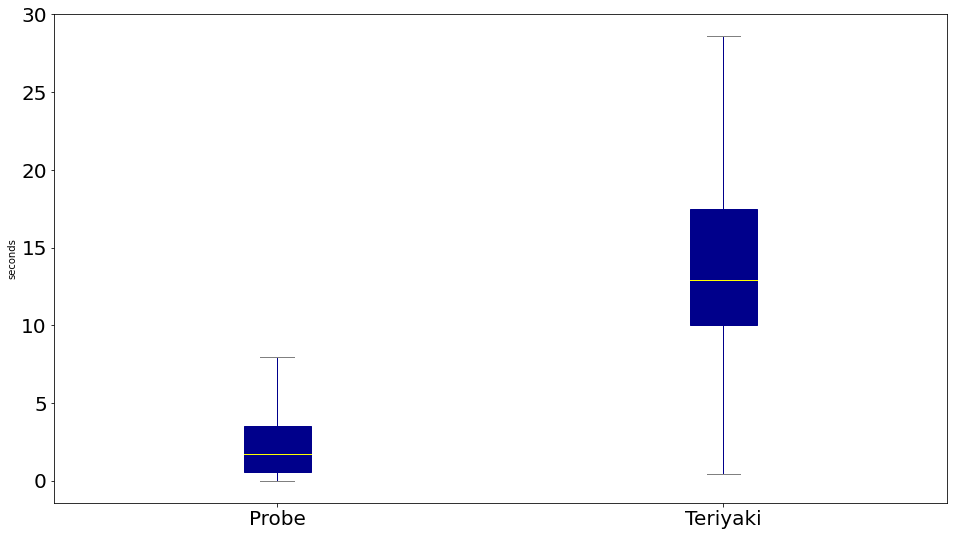

In [29]:
dft = pd.DataFrame(timings, columns=['Probe','Teriyaki'])

timings = np.load('./timings/timings.npy')

props = dict(boxes="DarkBlue", 
             whiskers="DarkBlue", 
             medians="Yellow", 
             caps="Gray")

boxplot = dft.plot.box(figsize=(16,9), 
                       fontsize=20, 
                       color=props, 
                       patch_artist=True,
                       xlabel="Solver",
                       ylabel="seconds",
                       showfliers=False)  

## Did we impact the natural language capabilities of GPT?

In [20]:
import subprocess

def GPT_Completion(texts):## Call the API key under your account (in a secure way)
    openai.api_key = "***REMOVED***"

    response = openai.Completion.create(engine="text-davinci-002",
                                        prompt =  texts,
                                        temperature = 0.6,
                                        top_p = 1,
                                        max_tokens = 600,
                                        frequency_penalty = 0,
                                        presence_penalty = 0,
                                        stop = "END")
    return print(response.choices[0].text)

def Teriyaki_Completion(texts):## Call the API key under your account (in a secure way)
    openai.api_key = "***REMOVED***"

    response = openai.Completion.create(engine="davinci:ft-teriyaki:teriyaki-001-2022-12-01-00-28-34",
                                        prompt =  texts,
                                        temperature = 0.6,
                                        top_p = 1,
                                        max_tokens = 600,
                                        frequency_penalty = 0,
                                        presence_penalty = 0,
                                        stop = "END")
    return print(response.choices[0].text)

query = "What is a Large Language Model?"

print("GPT Davinci:\n")
GPT_Completion(query)

print("\n===========\nTeriyaki:\n")
Teriyaki_Completion(query)

print("\nTesting queries that mix natural language and our planning model\n")

mixed_query = "If you solve this problem, what would be the last action taken?\n\
               Problem:\n\
               (:init\n(angle_joint angle0 joint1)\n(angle_joint angle345 joint2)\n(angle_joint angle0 joint3)\n\
               (in-centre joint3)\n(in-hand link1)\n(in-hand link2)\n(grasp gleft link1)\n(grasp gright link2))\n\
               (:goal(and\n(angle_joint angle285 joint1)\n(angle_joint angle285 joint2)\n(angle_joint angle315 joint3\
               )\n)\n)\n)\n\n\n###\n\n" ## The prompt ending we used in training should suggest to recall that 

print("\n===========\nGPT Davinci mixed query:")
GPT_Completion(mixed_query)

print("\n===========\nTeriyaki Mixed query:")
Teriyaki_Completion(mixed_query)

GPT Davinci:



A large language model is a statistical model that is trained on a large corpus of text data in order to predict the probability of a sequence of words. The model is typically a recurrent neural network (RNN) or a long short-term memory (LSTM) network.

Teriyaki:



A large language model is a model that is sufficiently large to contain a sufficiently large number of words.

If you want to build a good language model, you need a sufficiently large language model.

The size of a language model depends on the following:

The amount of data (and the size of the data)

The size of the vocabulary

The size of the training set

The size of the test set

The size of the output

The size of the vocab

The size of the training set

The size of the output

The size of the test set

The size of the input

The size of the output

The size of the training set

The size of the output

The size of the training set

The size of the output

The size of the input

The size of the output


## Transfer learning - No macro

### Learning from scratch

| Training set size | Job ID | Model ID | Accuracy |
|-------------------|----------------------------|------------------------------------------------------|-------|
| No macro - 1000   |ft-3fwBVR15jYUsva3pUC6OsTb4 | davinci:ft-teriyaki:teriyaki-003-2023-02-08-16-04-36 | 32.5% |
|                   |                            | **Probe planner**                                    | 98,6% |

### Learning from Teriyaki-001

| Training set size | Job ID | Model ID | Accuracy |
|-------------------|---------------------------|------------------------------------------------------|-------|
| No macro - 1000 | ft-fnYjeF0c5JHLVivXYtcURsQG | davinci:ft-teriyaki:teriyaki-002-2023-02-07-13-55-29 | 95.2% |
| No macro - 2000 | ft-ZdKuOAYYbedWMPvw0Pm2EV8c | davinci:ft-teriyaki:teriyaki-002-2023-02-07-19-44-07 | 98.8% |
|                 |                             | **Probe planner**                                    | 98,6% |

Run as many time as needed, but remember to update the base model in the call at the end!

In [25]:
!rm -r dataset/batches/no_macro &> /dev/null
!rm -r dataset/batches/validation/no_macro &> /dev/null
!rm -r dataset/batches/validation/results/no_macro
!mkdir dataset/batches/no_macro/
!mkdir dataset/batches/no_macro/problems
!mkdir dataset/batches/no_macro/plans
!mkdir dataset/batches/no_macro/plans_ipc
!mkdir dataset/batches/validation/results/no_macro
!mkdir dataset/batches/validation/results/no_macro/plans
!mkdir dataset/batches/validation/results/no_macro/val
!mkdir dataset/batches/validation/no_macro
!mkdir dataset/batches/validation/no_macro/plans
!mkdir dataset/batches/validation/no_macro/problems

import os
import subprocess
import shutil
import openai
import requests

## generate problems

%run generator/pddl_confgen.py 4 1000 -r 24 -co
!mv -v generator/problems/conditional/* dataset/batches/no_macro/problems > /dev/null

## generate plans

problems = sorted(os.listdir('./dataset/batches/no_macro/problems'))

for i, problem in enumerate(problems):
    
    result = subprocess.run(['./generator/probe', 
                             '-d', './dataset/domains/domain_m_0.pddl', 
                             '-i', './dataset/batches/no_macro/problems/' + problem,
                             '-o', './dataset/batches/no_macro/plans/m_0-' + str(problem.split('_',2)[2:][0])], 
                             stdout=subprocess.PIPE)
    print("Planning --- " + str(round((i / len(problems) * 100), 1)) +"%", end = '\r')

## convert to IPC    
    
plans = sorted(os.listdir('./dataset/batches/no_macro/plans/'))

for plan in plans:
    probe = open('./dataset/batches/no_macro/plans/' + plan, "r")
    val = open('./dataset/batches/no_macro/plans_ipc/' + plan.split(".")[0] + ".plan", 'w+')
    replacement = ""
    # using the for loop
    action_timing = 1
    for line in probe:
        line = line.lower()
        line = '%.3f' % (action_timing / 1000) + "00: " + line
        val.write(line)
        action_timing += 2

    probe.close()
    val.close()
    
print("Plans converted to IPC format")

## sort plans
## Uncomment only if you need to generate a validation dataset

plans_ipc = sorted(os.listdir('./dataset/batches/no_macro/plans_ipc/'))

for i, plan in enumerate(plans_ipc):
    if i < 1000:
        continue
    else:
        shutil.move('./dataset/batches/no_macro/problems/problem_conditional_' + plan.split("-")[1].split(".")[0] + ".pddl", 
                     'dataset/batches/validation/no_macro/problems/')
        shutil.move('./dataset/batches/no_macro/plans_ipc/' + plans_ipc[i], 'dataset/batches/validation/no_macro/plans/')

print('All problems and plans have been sorted into batches.')

# compile datasets

dataset = open('./dataset/batches/no_macro/teriyaki_no_macro.jsonl', 'w+')
plans_ipc = sorted(os.listdir('./dataset/batches/no_macro/plans_ipc/'))

for i, plan in enumerate(plans_ipc):
    plan_f = open('./dataset/batches/no_macro/plans_ipc/' + plan, "r")
    problem_f = open('./dataset/batches/no_macro/problems/problem_conditional_' + plan.split("-")[1].split(".")[0] + ".pddl", "r")
    lines = problem_f.readlines()

    dataset.write(repr('{"prompt":"\n--NO-MACRO\n(:init\n' + ''.join(lines[49:-1]).replace("    ", "") + 
          '\n\n###\n\n", "completion":" ' + plan_f.read().replace("    ", "") + ' END"}')[1:-1] + "\n")

dataset.close()

dataset = open('./dataset/batches/validation/no_macro/teriyaki_no_macro.jsonl', 'w+')
plans_ipc = sorted(os.listdir('./dataset/batches/validation/no_macro/plans/'))

for i, plan in enumerate(plans_ipc):
    plan_f = open('./dataset/batches/validation/no_macro/plans/' + plan, "r")
    problem_f = open('./dataset/batches/validation/no_macro/problems/problem_conditional_' + plan.split("-")[1].split(".")[0] + ".pddl", "r")
    lines = problem_f.readlines()

    dataset.write(repr('{"prompt":"\n--NO-MACRO\n(:init\n' + ''.join(lines[49:-1]).replace("    ", "") + 
          '\n\n###\n\n", "completion":" ' + plan_f.read().replace("    ", "") + ' END"}')[1:-1] + "\n")

dataset.close()

print("Datasets ready!")
print("Before training, run in a terminal\n\t>openai tools fine_tunes.prepare_data -f './dataset/batches/[YOUR_BATCH]/teriyaki.jsonl'")

# fine-tune starting from previous model

!openai -k ***REMOVED*** \
api fine_tunes.create -t './dataset/batches/no_macro/teriyaki_no_macro.jsonl' \
-v './dataset/batches/validation/no_macro/teriyaki_no_macro.jsonl' \
-m 'davinci' --suffix "teriyaki-003" --n_epochs 2

Writing conditional problem files to /home/alessio/planning/teriyaki/generator/problems/conditional...
Done.
All operations completed. Happy planning!


terminate called after throwing an instance of 'std::bad_alloc'
  what():  std::bad_alloc


Plans converted to IPC format
Datasets ready!
Before training, run in a terminal
	>openai tools fine_tunes.prepare_data -f './dataset/batches/[YOUR_BATCH]/teriyaki.jsonl'
Upload progress: 100%|████████████████████| 2.11M/2.11M [00:00<00:00, 2.85Git/s]
Uploaded file from ./dataset/batches/no_macro/teriyaki_no_macro.jsonl: file-QOcI8DCY5VZmg26iDHdMD5gQ
Found potentially duplicated files with name 'teriyaki_no_macro.jsonl', purpose 'fine-tune' and size 194536 bytes
file-DMReY0ylJ69c7yJDg8TNhXUm
Enter file ID to reuse an already uploaded file, or an empty string to upload this file anyway: ^C



## Check Teriyaki no macro planning accuracy on the validation set
Update `engine` field and uncomment sections as needed.

In [57]:
import os
import openai
import subprocess

def GPT_Plan(problem_path):## Call the API key under your account (in a secure way)
    openai.api_key = "***REMOVED***"
    problem_f = open(problem_path)
    lines = problem_f.readlines()
    problem_query = '\n--NO-MACRO\n(:init\n' + ''.join(lines[49:-1]).replace("    ", "") + '\n\n###\n\n'
    problem_f.close()
    response = openai.Completion.create(engine="davinci:ft-teriyaki:teriyaki-002-2023-02-07-19-44-07",
                                        prompt =  problem_query,
                                        top_p = 1,       # modify ONLY top_p or temperature, not both       
                                        temperature = 0, # argmax
                                        max_tokens = 1800, # increased to accomodate for longer plans
                                        presence_penalty = 0, # -2 < x < 2, negative favors repetitions
                                        frequency_penalty = 0,
                                        # best_of = 4, # 3-5 work well for code completion
                                        stop = "END")
    
    if response.choices[0].finish_reason == "length":
        print("WARNING: the query for problem " + problem_path + " has exceed the max_tokens limit.")
    return response.choices[0].text


problems = sorted(os.listdir('./dataset/batches/validation/no_macro/problems/'))

# Generating validation dataset of plans

print("Generating {0} validation plans dataset using no macro model.".format(len(problems)))

for i, problem in enumerate(problems):
    print("GPT-Planning --- {0}%".format(round((i / len(problems) * 100), 1)), end = '\r')
    problem_path = './dataset/batches/validation/no_macro/problems/' + problem
    plan = GPT_Plan(problem_path)
    plan_f = open('./dataset/batches/validation/results/no_macro/plans/{0}'.format(problem)[:-5] + ".plan", 'w+')
    plan_f.write(plan[1:])
    plan_f.close()
print("GPT-Planning --- {0}%".format(round((i / len(problems) * 100), 1)))

# Validate with VAL

print("Starting VAL validation on the generated dataset.")
invalid_plans = 0
success = 0
for i, problem in enumerate(problems):
    if i > 0:
        print("Validating --- {0}% --- Current success rate {1}%".format(
            round((i / len(problems) * 100), 1),
            round((success / i * 100), 1)), end = '\r')
    result_f = open('./dataset/batches/validation/results/no_macro/val/' + problem, 'w+')
    result = subprocess.run(['./generator/Validate', 
                             './dataset/domains/domain_m_0.pddl', 
                             './dataset/batches/validation/no_macro/problems/' + problem,
                             './dataset/batches/validation/results/no_macro/plans/{0}'.format(problem)[:-5] + ".plan"], 
                             stdout=subprocess.PIPE)
    result_f.write(str(result))
    result_f.close()
    if ("Plan failed to execute" in str(result)) or ("Bad plan description!" in str(result)):
        invalid_plans += 1
    else:
        success += 1
print("Validating --- {0}% --- Current success rate {1}%".format(
    round((i / len(problems) * 100), 1),
    round((success / i * 100), 1)))

print('Teriyaki-no-macro failed to plan %i problems' % invalid_plans)
    
print("Validation complete!!")

Generating 84 validation plans dataset using no macro model.
GPT-Planning --- 98.8%
Starting VAL validation on the generated dataset.
Validating --- 98.8% --- Current success rate 98.8%%
Teriyaki-no-macro failed to plan 2 problems
Validation complete!!


## Check Teriyaki no macro planning accuracy on test set
Reduced to 100

### Learning from Teriyaki-001

| Training set size | Job ID | Model ID | Accuracy |
|-------------------|---------------------------|------------------------------------------------------|-------|
| No macro - 2000 | ft-ZdKuOAYYbedWMPvw0Pm2EV8c | davinci:ft-teriyaki:teriyaki-002-2023-02-07-19-44-07 | 94,0% |
|                 |                             | **Probe planner**                                    | 98,6% |

In [1]:
import os
import openai
import subprocess

# Uncomment only if you need to generate a new test set
# %run generator/pddl_confgen.py 4 1000 -r 24 -co
# !mv -v generator/problems/conditional/* dataset/test/problems > /dev/null


def GPT_Plan(problem_path):## Call the API key under your account (in a secure way)
    openai.api_key = "***REMOVED***"
    problem_f = open(problem_path)
    lines = problem_f.readlines()
    problem_query = '\n--NO-MACRO\n(:init\n' + ''.join(lines[49:-1]).replace("    ", "") + '\n\n###\n\n'
    problem_f.close()
    response = openai.Completion.create(engine="davinci:ft-teriyaki:teriyaki-002-2023-02-07-19-44-07",
                                        prompt =  problem_query,
                                        top_p = 1,       # modify ONLY top_p or temperature, not both       
                                        temperature = 0, # argmax
                                        max_tokens = 1800,
                                        presence_penalty = 0, # -2 < x < 2, negative favors repetitions
                                        frequency_penalty = 0,
                                        # best_of = 4, # 3-5 work well for code completion
                                        stop = "END")
    
    if response.choices[0].finish_reason == "length":
        print("WARNING: the query for problem " + problem_path + " has exceed the max_tokens limit.")
    return response.choices[0].text

n_samples = 100 ## limit number of test samples

problems = sorted(os.listdir('./dataset/test/problems/'))

# Teriyaki planning

print("Planning {0} problems with Teriyaki.".format(min(n_samples, len(problems))))

for i, problem in enumerate(problems):
    if i == n_samples: ## limit number of iterations
            break
    print("GPT-Planning --- {0}%".format(round((i / len(problems) * 100), 1)), end = '\r')
    problem_path = './dataset/test/problems/' + problem
    plan = GPT_Plan(problem_path)
    plan_f = open('./dataset/test/plans_no_macro/{0}'.format(problem)[:-5] + ".plan", 'w+')
    plan_f.write(plan[1:])
    plan_f.close()
print("GPT-Planning --- {0}%".format(round((i / len(problems) * 100), 1)))

# Validate with VAL

print("Starting VAL validation on the generated dataset.")
invalid_plans = 0
success = 0
for i, problem in enumerate(problems):
    if i == n_samples: ## limit number of iterations
            break
    if i > 0:
        print("Validating --- {0}% --- Current success rate {1}%".format(
            round((i / len(problems) * 100), 1),
            round((success / i * 100), 1)), end = '\r')
    result_f = open('./dataset/test/val/' + problem, 'w+')
    result = subprocess.run(['./generator/Validate', 
                             './dataset/domains/domain_m_0.pddl', 
                             './dataset/test/problems/' + problem,
                             './dataset/test/plans_no_macro/{0}'.format(problem)[:-5] + ".plan"], 
                             stdout=subprocess.PIPE)
    result_f.write(str(result))
    result_f.close()
    if ("Plan failed to execute" in str(result)) or ("Bad plan description!" in str(result)):
        invalid_plans += 1
    else:
        success += 1
print("Validating --- {0}% --- Current success rate {1}%".format(
    round((i / len(problems) * 100), 1),
    round((success / i * 100), 1)))

print('Teiyaki failed %i plans' % invalid_plans)

print("Validation complete!!")

Planning 100 problems with Teriyaki.
GPT-Planning --- 10.0%
Starting VAL validation on the generated dataset.
Validating --- 10.0% --- Current success rate 94.0%
Teiyaki failed 6 plans
Validation complete!!


## Compare no macro planning times and length on test set
Probe failed plans are ignored

In [1]:
import numpy as np
import pandas as pd
import subprocess
import os
import openai
import time
from tempfile import TemporaryFile

def GPT_Plan(problem_path):## Call the API key under your account (in a secure way)
    openai.api_key = "***REMOVED***"
    problem_f = open(problem_path)
    lines = problem_f.readlines()
    problem_query = '\n--NO-MACRO\n(:init\n' + ''.join(lines[49:-1]).replace("    ", "") + '\n\n###\n\n'
    problem_f.close()
    response = openai.Completion.create(engine="davinci:ft-teriyaki:teriyaki-002-2023-02-07-19-44-07",
                                        prompt =  problem_query,
                                        top_p = 1,       # modify ONLY top_p or temperature, not both       
                                        temperature = 0, # argmax
                                        max_tokens = 1900,
                                        presence_penalty = 0, # -2 < x < 2, negative favors repetitions
                                        frequency_penalty = 0,
                                        # best_of = 4, # 3-5 work well for code completion
                                        stop = "END")
    
    if response.choices[0].finish_reason == "length":
        print("WARNING: the query for problem " + problem_path + " has exceed the max_tokens limit.")
    return response.choices[0].text


problems = sorted(os.listdir('./dataset/test/problems/'))
n_samples = 1000 ## limit number of samples
print("{0} problems loaded".format(min(n_samples, len(problems))))

results = np.empty([2,6])
timings = np.empty([min(n_samples, len(problems)),2])

### Test Probe

comparison_results = []
planning_times = []
planning_steps = []
fails = 0

print("Running Probe tests --- 0%", end = '\r')
for j, problem in enumerate(problems):
    if j == n_samples: ## limit number of iterations
            break
    result = subprocess.run(['./generator/probe', 
                             '-d', './dataset/domains/domain_m_0.pddl', 
                             '-i', './dataset/test/problems/' + problem,
                             '-o', './dataset/test/plans_no_macro/m_0-' + str(problem.split('_',2)[2:][0])], 
                             stdout=subprocess.PIPE)

    # considering failures plans that took more than 1sec or that failed planning
    try:
        planning_steps.append(float(result.stdout.decode("utf8").split('steps: ')[1].split('\n')[0]))
        ptime = float(result.stdout.decode("utf8").split('Time: ')[1].split('\n')[0])
        planning_times.append(ptime)

    except IndexError:
        planning_times.append(np.nan) 
        fails+=1

    print("Running Probe tests --- " + str(round((j / min(n_samples, len(problems)) * 100), 1)) +"%", end = '\r')

print("Running Probe tests --- 100%")
timings[:,0] = planning_times

planning_times = np.array(planning_times)
planning_steps = np.array(planning_steps)

comparison_results.append(np.nanmean(planning_steps))
comparison_results.append(np.nanmin(planning_times))
comparison_results.append(np.nanmax(planning_times))
comparison_results.append(np.nanmean(planning_times))
comparison_results.append(np.nanstd(planning_times))

comparison_results.append(fails)

results[0] = comparison_results

### Test Teriyaki

comparison_results = []
planning_times = []
planning_steps = []
fails = 0

t = time.localtime()
current_time = time.strftime("%H:%M:%S", t)
print("Starting GPT test at " + current_time)

print("Running Teriyaki tests --- 0%", end = '\r')
for j, problem in enumerate(problems):
    if j == n_samples: ## limit number of iterations
            break
    st = time.time()
    result = GPT_Plan('./dataset/test/problems/' + problem)
    et = time.time()
    # considering failures plans that took more than 1sec or that failed planning
    try:
        planning_steps.append(float(result.count('\n')))
        planning_times.append(et - st)

    except IndexError:
        planning_times.append(np.nan) 
        fails+=1

    print("Running Teriyaki tests --- " + str(round((j / len(problems) * 100), 1)) +"%", end = '\r')

print("Running Teriyaki tests --- 100%")

t = time.localtime()
current_time = time.strftime("%H:%M:%S", t)
print("Finished GPT test at " + current_time)

timings[:,1] = planning_times

planning_times = np.array(planning_times)
planning_steps = np.array(planning_steps)

comparison_results.append(np.nanmean(planning_steps))
comparison_results.append(np.nanmin(planning_times))
comparison_results.append(np.nanmax(planning_times))
comparison_results.append(np.nanmean(planning_times))
comparison_results.append(np.nanstd(planning_times))

comparison_results.append(fails)

results[1] = comparison_results

with open('./timings/results_no_macro.npy', 'wb') as f:
    np.save(f, results)
    
with open('./timings/timings_no_macro.npy', 'wb') as f:
    np.save(f, timings)
    
print("Tests completed")


1000 problems loaded
Running Probe tests --- 100%%
Starting GPT test at 17:22:24
Running Teriyaki tests --- 100%%
Finished GPT test at 21:25:58
Tests completed


## Results table 

In [28]:
import numpy as np

results = np.load('./timings/results_no_macro.npy')

results_table = pd.DataFrame(results, columns=('avg_steps', 'min', 'max', 'avg', 'std', 'fails'))

df = pd.DataFrame({'SOLVER': ('Probe', 'Teiryaki')})
df = pd.concat([df, results_table],axis=1)
df = df.astype({"fails":"int"})

df.style.\
    format(precision=3).\
    set_table_attributes('style="font-size: 20px"')

,SOLVER,avg_steps,min,max,avg,std,fails
0,Probe,22.137,0.006,43.768,2.788,3.303,17
1,Teiryaki,19.158,0.440,54.705,14.614,7.163,0


## Results boxplot

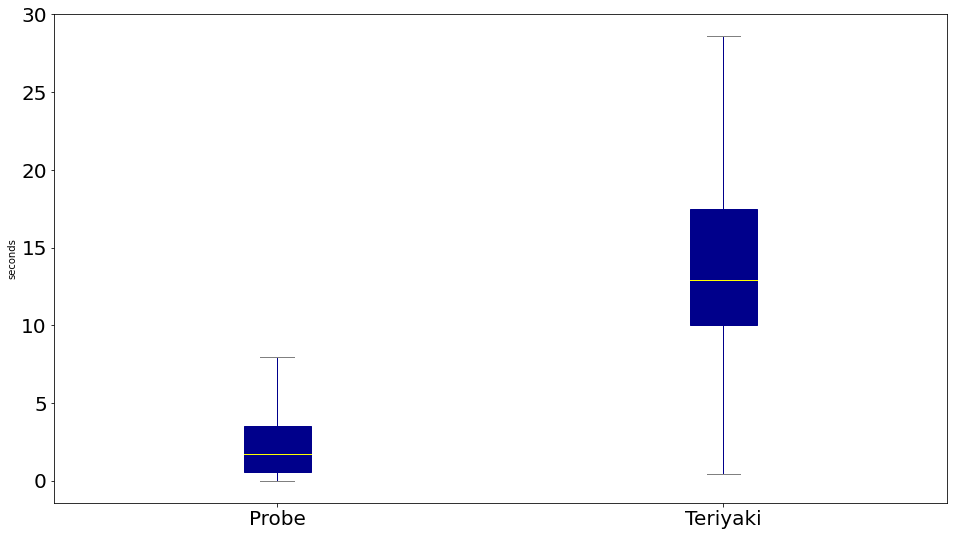

In [27]:
import numpy as np

timings = np.load('./timings/timings_no_macro.npy')

dft = pd.DataFrame(timings, columns=['Probe','Teriyaki'])

props = dict(boxes="DarkBlue", 
             whiskers="DarkBlue", 
             medians="Yellow", 
             caps="Gray")

boxplot = dft.plot.box(figsize=(16,9), 
                       fontsize=20, 
                       color=props, 
                       patch_artist=True,
                       xlabel="Solver",
                       ylabel="seconds",
                       showfliers=False)  

## Fine-tuning Teriyaki for dual domain

In [ ]:
!rm -r dataset/batches/dual &> /dev/null
!rm -r dataset/batches/validation/dual &> /dev/null
!rm -r dataset/batches/validation/results/dual
!mkdir dataset/batches/dual/
!mkdir dataset/batches/dual/problems
!mkdir dataset/batches/dual/plans
!mkdir dataset/batches/dual/plans_ipc
!mkdir dataset/batches/validation/results/dual
!mkdir dataset/batches/validation/results/dual/plans
!mkdir dataset/batches/validation/results/dual/val
!mkdir dataset/batches/validation/dual
!mkdir dataset/batches/validation/dual/plans
!mkdir dataset/batches/validation/dual/problems

import os
import subprocess
import shutil
import openai
import requests
import random

## generate problems

%run generator/pddl_confgen.py 4 1200 -r 24 -co
!mv -v generator/problems/conditional/* dataset/batches/dual/problems > /dev/null

## generate plans

problems = sorted(os.listdir('./dataset/batches/dual/problems'))

for i, problem in enumerate(problems):
    if i < (len(problem)/2):
        result = subprocess.run(['./generator/probe', 
                                 '-d', './dataset/domains/domain_m_0.pddl', 
                                 '-i', './dataset/batches/dual/problems/' + problem,
                                 '-o', './dataset/batches/dual/plans/m_0-' + str(problem.split('_',2)[2:][0])], 
                                 stdout=subprocess.PIPE)
        print("Planning --- " + str(round((i / len(problems) * 100), 1)) +"%", end = '\r')
    if i >= (len(problem)/2):
        result = subprocess.run(['./generator/probe', 
                                 '-d', './dataset/domains/domain_m_25_B.pddl', 
                                 '-i', './dataset/batches/dual/problems/' + problem,
                                 '-o', './dataset/batches/dual/plans/m_25_B-' + str(problem.split('_',2)[2:][0])], 
                                 stdout=subprocess.PIPE)
        print("Planning --- " + str(round((i / len(problems) * 100), 1)) +"%", end = '\r')

## convert to IPC    
    
plans = sorted(os.listdir('./dataset/batches/dual/plans/'))

for plan in plans:
    probe = open('./dataset/batches/dual/plans/' + plan, "r")
    val = open('./dataset/batches/dual/plans_ipc/' + plan.split(".")[0] + ".plan", 'w+')
    replacement = ""
    # using the for loop
    action_timing = 1
    for line in probe:
        line = line.lower()
        line = '%.3f' % (action_timing / 1000) + "00: " + line
        val.write(line)
        action_timing += 2

    probe.close()
    val.close()
    
print("Plans converted to IPC format")

## sort plans
## Uncomment only if you need to generate a validation dataset

plans_ipc = sorted(os.listdir('./dataset/batches/dual/plans_ipc/'))

for i, plan in enumerate(plans_ipc):
    if i < 1000:
        continue
    else:
        shutil.move('./dataset/batches/dual/problems/problem_conditional_' + plan.split("-")[1].split(".")[0] + ".pddl", 
                     'dataset/batches/validation/dual/problems/')
        shutil.move('./dataset/batches/dual/plans_ipc/' + plans_ipc[i], 'dataset/batches/validation/dual/plans/')

print('All problems and plans have been sorted into batches.')

# compile datasets

dataset = open('./dataset/batches/dual/teriyaki_dual.jsonl', 'w+')
plans_ipc = sorted(os.listdir('./dataset/batches/dual/plans_ipc/'))

for i, plan in enumerate(plans_ipc):
    plan_f = open('./dataset/batches/dual/plans_ipc/' + plan, "r")
    problem_f = open('./dataset/batches/dual/problems/problem_conditional_' + plan.split("-")[1].split(".")[0] + ".pddl", "r")
    lines = problem_f.readlines()
    if "m_25_B" in plan:
        dataset.write(repr('{"prompt":"\n(:init\n' + ''.join(lines[49:-1]).replace("    ", "") + 
              '\n\n###\n\n", "completion":" ' + plan_f.read().replace("    ", "") + ' END"}')[1:-1] + "\n")
    else:
        dataset.write(repr('{"prompt":"\n--NO-MACRO\n(:init\n' + ''.join(lines[49:-1]).replace("    ", "") + 
              '\n\n###\n\n", "completion":" ' + plan_f.read().replace("    ", "") + ' END"}')[1:-1] + "\n")

dataset.close()

lines = open(dataset).readlines()
random.shuffle(lines)
open(dataset, 'w').writelines(lines)

dataset = open('./dataset/batches/validation/dual/teriyaki_dual.jsonl', 'w+')
plans_ipc = sorted(os.listdir('./dataset/batches/validation/dual/plans/'))

for i, plan in enumerate(plans_ipc):
    plan_f = open('./dataset/batches/validation/dual/plans/' + plan, "r")
    problem_f = open('./dataset/batches/validation/dual/problems/problem_conditional_' + plan.split("-")[1].split(".")[0] + ".pddl", "r")
    lines = problem_f.readlines()

    dataset.write(repr('{"prompt":"\n--NO-MACRO\n(:init\n' + ''.join(lines[49:-1]).replace("    ", "") + 
              '\n\n###\n\n", "completion":" ' + plan_f.read().replace("    ", "") + ' END"}')[1:-1] + "\n")

dataset.close()

lines = open(dataset).readlines()
random.shuffle(lines)
open(dataset, 'w').writelines(lines)

print("Datasets ready!")
print("Before training, run in a terminal\n\t>openai tools fine_tunes.prepare_data -f './dataset/batches/[YOUR_BATCH]/teriyaki.jsonl'")

# fine-tune starting from previous model

# !openai -k ***REMOVED*** \
# api fine_tunes.create -t './dataset/batches/dual/teriyaki_dual.jsonl' \
# -v './dataset/batches/validation/dual/teriyaki_dual.jsonl' \
# -m 'davinci' --suffix "teriyaki-003" --n_epochs 2

## Teriyaki dual domain accuracy on test set
Running tests designed for Teriyaki against Teriyaki no macro. Testing only 100 samples.

### Learning from Teriyaki-004

| Training set size | Job ID | Model ID | Accuracy |
|-------------------|---------------------------|------------------------------------------------------|-------|
| No macro - 2000 | ft-ZdKuOAYYbedWMPvw0Pm2EV8c | davinci:ft-teriyaki:teriyaki-002-2023-02-07-19-44-07 | 94,0% |
|                 |                             | **Probe planner**                                    | 98,6% |

In [12]:
import os
import openai
import subprocess
import numpy as np

# Uncomment only if you need to generate a new test set
# %run generator/pddl_confgen.py 4 1000 -r 24 -co
# !mv -v generator/problems/conditional/* dataset/test/problems > /dev/null


def GPT_Plan(problem_path):## Call the API key under your account (in a secure way)
    openai.api_key = "***REMOVED***"
    problem_f = open(problem_path)
    lines = problem_f.readlines()
    problem_query = '\n(:init\n' + ''.join(lines[49:-1]).replace("    ", "") + '\n\n###\n\n'
    problem_f.close()
    response = openai.Completion.create(engine="davinci:ft-teriyaki:teriyaki-002-2023-02-07-19-44-07",
                                        prompt =  problem_query,
                                        top_p = 1,       # modify ONLY top_p or temperature, not both       
                                        temperature = 0, # argmax
                                        max_tokens = 1800,
                                        presence_penalty = 0, # -2 < x < 2, negative favors repetitions
                                        frequency_penalty = 0,
                                        # best_of = 4, # 3-5 work well for code completion
                                        stop = "END")
    
    if response.choices[0].finish_reason == "length":
        print("WARNING: the query for problem " + problem_path + " has exceed the max_tokens limit.")
    return response.choices[0].text

n_samples = 100
planning_steps = []

problems = sorted(os.listdir('./dataset/test/problems/'))

# Teriyaki planning

print("Planning {0} problems with Teriyaki.".format(min(n_samples, len(problems))))

for i, problem in enumerate(problems):
    if i == n_samples: ## limit number of iterations
            break
    print("GPT-Planning --- {0}%".format(round((i / len(problems) * 100), 1)), end = '\r')
    problem_path = './dataset/test/problems/' + problem
    plan = GPT_Plan(problem_path)
    planning_steps.append(float(plan.count('\n')))
    plan_f = open('./dataset/test/crosstest/{0}'.format(problem)[:-5] + ".plan", 'w+')
    plan_f.write(plan[1:])
    plan_f.close()
print("GPT-Planning --- {0}%".format(round((i / len(problems) * 100), 1)))

# Validate with VAL

print("Starting VAL validation on the generated dataset.")
invalid_plans = 0
success = 0
for i, problem in enumerate(problems):
    if i == n_samples: ## limit number of iterations
            break
    if i > 0:
        print("Validating --- {0}% --- Current success rate {1}%".format(
            round((i / min(n_samples, len(problems)) * 100), 1),
            round((success / i * 100), 1)), end = '\r')
    result_f = open('./dataset/test/val/' + problem, 'w+')
    result = subprocess.run(['./generator/Validate', 
                             './dataset/domains/domain_m_25_B.pddl', 
                             './dataset/test/problems/' + problem,
                             './dataset/test/crosstest/{0}'.format(problem)[:-5] + ".plan"], 
                             stdout=subprocess.PIPE)
    result_f.write(str(result))
    result_f.close()
    if ("Plan failed to execute" in str(result)) or ("Bad plan description!" in str(result)):
        invalid_plans += 1
    else:
        success += 1
print("Validating --- {0}% --- Success rate {1}%".format(
    round(((i / min(n_samples, len(problems))) * 100), 1),
    round((success / i * 100), 1)))

print('Teriyaki failed %i plans' % invalid_plans)
planning_steps = np.array(planning_steps)
print(str(np.average(planning_steps)/len(planning_steps)))

print("Validation complete!!")

Validating --- 100.0% --- Current success rate 2.0%
Teiyaki failed 98 plans
[]
nan
Validation complete!!


## Final result comparison -  Table

In [23]:
import numpy as np

results_1 = np.load('./timings/results.npy')
results_2 = np.load('./timings/results_no_macro.npy')

results = np.empty([4,6])

results[:2,:] = results_1
results[2:4,:] = results_2

results_table = pd.DataFrame(results, columns=('avg_steps', 'min', 'max', 'avg', 'std', 'fails'))

df = pd.DataFrame({'Solver/Domain': ('Probe/Macro', 'Teiryaki/Macro', 'Probe/No Macro', 'Teiryaki/No Macro')})
df = pd.concat([df, results_table],axis=1)
df = df.astype({"fails":"int"})

df.style.\
    format(precision=3).\
    set_table_attributes('style="font-size: 20px"')

,Solver/Domain,avg_steps,min,max,avg,std,fails
0,Probe/Macro,11.111,0.009,36.711,2.112,3.470,12
1,Teiryaki/Macro,10.953,1.033,54.323,8.985,4.770,0
2,Probe/No Macro,22.137,0.006,43.768,2.788,3.303,17
3,Teiryaki/No Macro,19.158,0.440,54.705,14.614,7.163,0


## Final result comparison - Boxplot

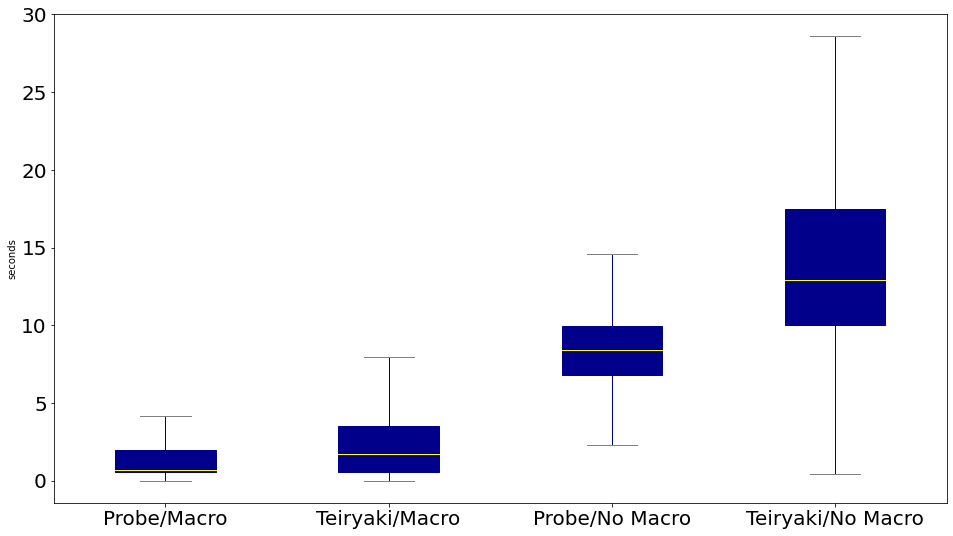

In [33]:
import numpy as np

timings_1 = np.load('./timings/timings.npy')
timings_2 = np.load('./timings/timings_no_macro.npy')

timings = np.empty([1000,4])

timings[:,:2] = timings_1
timings[:,2:4] = timings_2

timings[:,[1, 2]] = timings[:,[2, 1]]

dft = pd.DataFrame(timings, columns=['Probe/Macro','Teiryaki/Macro', 'Probe/No Macro', 'Teiryaki/No Macro'])

props = dict(boxes="DarkBlue", 
             whiskers="DarkBlue", 
             medians="Yellow", 
             caps="Gray")

boxplot = dft.plot.box(figsize=(16,9), 
                       fontsize=20, 
                       color=props, 
                       patch_artist=True,
                       xlabel="Solver",
                       ylabel="seconds",
                       showfliers=False)  